# Multilayer Perceptron (MLP)

The purpose of this notebook is to practice implementing the multilayer perceptron (MLP) model from scratch.




The MLP is a type of neural network model, that composes multiple affine transformations together, and applying a pointwise nonlinearity in between. Equations for the hidden layers $\boldsymbol{h}^{(k)}\in\mathbb{R}^{n_k}$, $k=0,1,...,L$ with $L$ the number of hidden layers in the model, and the output $\hat{\boldsymbol{y}}\in\mathbb{R}^{n_{L+1}}$ are given in the following:

$$
\begin{align}
\boldsymbol{h}^{(0)} &:= \boldsymbol{x},\\
\boldsymbol{a}^{(k)} &=  \boldsymbol{W}^{(k-1)} \boldsymbol{h}^{(k-1)} + \boldsymbol{b}^{(k-1)},\\
\boldsymbol{h}^{(k)} &= \sigma( \boldsymbol{a}^{(k)}),\qquad k=1,\ldots, L,\\
\hat{\boldsymbol{y}} &= \sigma_{out}\left( \boldsymbol{W}^{(L)} \boldsymbol{h}^{(L)} + \boldsymbol{b}^{(L)} \right),
\end{align}
$$

where $\boldsymbol x\in\mathbb{R}^D$ is the input vector, $\boldsymbol{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_{k}}$ are the weights, $\boldsymbol{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ are the biases, $\sigma, \sigma_{out}: \mathbb{R}\mapsto\mathbb{R}$ are activation functions that operate element-wise, $n_k$ is the number of units in the $k$-th hidden layer, and we have set $n_0 := D$. Moreover, $\boldsymbol{a}^{(k)}$ is called the pre-activation and $\boldsymbol{h}^{(k)}$ the post-activation of layer $k$.

#### Test Cases

Some of the tasks in this notebook are followed by cells that you can use to verify your solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Imports used for testing.
import numpy.testing as npt

## 1. Data preprocessing

In this notebook we will use the California Housing data, which you have already seen in week 2 (kNN notebook).

In [6]:
# Load the dataset

from sklearn.datasets import fetch_california_housing

california_housing_data = fetch_california_housing()

# get features and target
X = california_housing_data.data
y = california_housing_data.target

# Print details of dataset
print(california_housing_data['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

As usual, we create a train and test split of the data.

In [7]:
# shuffling the rows in X and y
rng = np.random.default_rng(2)
p = rng.permutation(len(y))
Xp = X[p]
yp = y[p]

# we split train to test as 80:20
split_rate = 0.8
X_train, X_test = np.split(Xp, [int(split_rate*(Xp.shape[0]))])
y_train, y_test = np.split(yp, [int(split_rate*(yp.shape[0]))])

We then standardise the train and test data. It is important to standardize after applying the train-test split to prevent any information leakage from the test set into the train set, which can lead to over-optimistic results and unrealistic performance evaluations.

In [8]:
## EDIT THIS FUNCTION
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X, axis = 0) ## <-- EDIT THIS LINE
    sigma = np.std(X, axis = 0) ## <-- EDIT THIS LINE
    X_std = (X - mu) / sigma ## <-- EDIT THIS LINE
    return X_std

In [9]:
# standardize train and test data
X_train = standardise(X_train)
X_test = standardise(X_test, X_train_=X_train)

## 2. Implementation of 3-layer MLP

Now you should implement an MLP regression model in numpy. The model will have three hidden layers with 64 neurons each, and using a ReLU activation function. The final output layer will be a single neuron with no activation function to predict the target variable $y$.

The building block of the model is the dense (or fully-connected) layer. The following function should implement the affine transformation of this layer, given kernel and bias parameters and the input to the layer. It should return the layer pre-activations (no activation function).

In [86]:
## EDIT THIS FUNCTION
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in if the input features dimension.
        W (np.ndarray): h_out x h_in array for kernel matrix parametersm, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X]) ## <-- EDIT THIS LINE
    return a

The hidden layers of our model will use a *ReLU* activation function, given by:

$$\sigma_r(x)=\max(0,x)$$

In the following cell, you should implement the *ReLU* activation and its gradient, which will be required in the backpropagation of the MLP.

In [100]:
## EDIT THIS FUNCTION
def relu_activation(a):
    """ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    a[a < 0] = 0
    h = a ## <-- EDIT THIS LINE
    return h

## EDIT THIS FUNCTION
def grad_relu_activation(a):
    """Gradient of ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    sigmas = relu_activation(a)
    grad = np.zeros_like(a)
    grad[a>0] = 1 ## <-- EDIT THIS LINE
    return grad

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{64 \times 8}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{64}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{64\times 64}$, $k=1, 2$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{64}$, $k=1, 2$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{1 \times 64}$
* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{1}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation](http://proceedings.mlr.press/v9/glorot10a.html). The bias parameters will be initialised to zeros.

In [101]:
# fix seed for random numbers
np.random.seed(42)

# create the parameters using Glorot initialisation
var0 = 2. / (64 + 8)
W0 = np.random.randn(64, 8) * np.sqrt(var0)
b0 = np.zeros(64)

var1 = 2. / (64 + 64)
W1 = np.random.randn(64, 64) * np.sqrt(var1)
b1 = np.zeros(64)

var2 = 2. / (64 + 64)
W2 = np.random.randn(64, 64) * np.sqrt(var2)
b2 = np.zeros(64)

var3 = 2. / (1 + 64)
W3 = np.random.randn(1, 64) * np.sqrt(var3)
b3 = np.zeros(1)

You should use these parameters and your `dense` function to create the MLP model. Remember that the hidden layers of the model should use a ReLU activation, and the output of the model should not use an activation function.

In [102]:
def mlp_3layers(X):
    """3-layer MLP with ReLU activation

    Parameters:
        X: K x 8 array of inputs
        seed (float): Seed for random numbers epsilon

    Returns:
        y:  K x 1 output array
    """
    if X.ndim == 1:
        # If one example passed, add a dummy dimension for the batch.
        X = X.reshape(1, -1)

    # compose 3-layer MLP
    h = X
    a = dense(h, W0, b0)
    h = relu_activation(a)
    a = dense(h, W1, b1)
    h = relu_activation(a)
    a = dense(h, W2, b2)
    h = relu_activation(a)
    y = dense(h, W3, b3)
    return y

We can now make a prediction with this simple MLP model.

In [103]:
# Get the output of your initialised model
y_hat_train = mlp_3layers(X_train)

In [104]:
mlp_3layers(X_train[100])

array([[-0.01139598]])

**Test Cases:** To verify your implementation of `relu_activation`, `dense`, `standardise`, you should expect the following cells to execute without error messages.

In [105]:
# The two lines shoud verify your implementation of
# relu_activation, dense, and standardise functions.
npt.assert_allclose(mlp_3layers(X_train[10]), 0.2109034)
npt.assert_allclose(mlp_3layers(X_train[100]), -0.01139598)

## 3. Implementation of general MLP model



We also implement two alternative activation functions. The *sigmoid* activation function $\sigma(x)$ is given by:

$$\sigma_s(x) = \frac{1}{1+\exp(-x)},$$

and the *tanh* activation is given by:

$$\sigma_t(x)=\frac{\exp(x)-\exp(-x)}{exp(x)+exp(-x)}=\frac{2}{1+\exp(-2x)}-1$$

In the following you need to implement both activation functions and their gradients.

In [106]:
## EDIT THIS FUNCTION
def tanh_activation(a):
    """Tanh activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = 2/(1 + np.exp(-2 * a)) - 1 ## <-- EDIT THIS LINE
    return h

## EDIT THIS FUNCTION
def grad_tanh_activation(a):
    """Gradient of Tanh activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = 4 * np.exp(-2 * a) / (1 + np.exp(-2 * a))**2 ## <-- EDIT THIS LINE
    return grad

In [107]:
## EDIT THIS FUNCTION
def sigmoid_activation(a):
    """Sigmoid activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = 1 / (1 + np.exp(-a)) ## <-- EDIT THIS LINE
    return h

## EDIT THIS FUNCTION
def grad_sigmoid_activation(a):
    """Gradient of Sigmoid activation function.

    Parameters:
        a: K x h_out array of pre-activations.

    Returns:
        grad: K x h_out gradient array of post-activations.
    """
    # compute gradient
    grad = np.exp(-a) / (1 + np.exp(-a))**2 ## <-- EDIT THIS LINE
    return grad

**Test Cases:** To verify your implementation of `tanh_activation`, `grad_tanh_activation`, `sigmoid_activation`, and `grad_sigmoid_activation` run the following cell:

In [108]:
### Test Cases:

# tanh (test against np.tanh)
npt.assert_allclose(tanh_activation(3), np.tanh(3))
npt.assert_allclose(tanh_activation(-3), np.tanh(-3))

# sigmoid
npt.assert_allclose(sigmoid_activation(2.5),  0.9241418199787566)
npt.assert_allclose(sigmoid_activation(-3), 0.04742587317756678)

# gradient of tanh
npt.assert_allclose(grad_tanh_activation(2), 0.07065082485316443)
npt.assert_allclose(grad_tanh_activation(-1), 0.41997434161402614)

# gradient of sigmoid
npt.assert_allclose(grad_sigmoid_activation(2), 0.10499358540350662)
npt.assert_allclose(grad_sigmoid_activation(-1), 0.19661193324148185)



To generalise our code, we write a MLP class where we can choose the number of layers and dimensions flexibely. Our strategy is to define `layers` attribute that stores all information on the layers as a list of dictionaries, with keys `"W"` corresponding to the weights $\boldsymbol{W}^{(k)}\in\mathbb{R}^{n_{k+1}\times n_{k}}$, `"b"` to the biases $\boldsymbol{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$ and `"activation"` for the activation functions $\sigma^{(k)}: \mathbb{R}\mapsto\mathbb{R}$. Below is an illustration for two layers. You will have to implement a method `add_layer` that adds a layer to to the MLP.

![layers](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/mlp.drawio.svg)

Once the architecture of the MLP is defined one can make predictions by computing a forward pass. You will implement this in the `predict` method of the MLP class, which returns the predication and the all the pre-activations and post-activations in the forward pass (again as a list of dictionaries with keys `"a"` and `"h"` as visualised below). We need the information from the forward pass later for the backpropagation.

![forward-pass](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/mlp-forward.drawio.svg)

In [113]:
# A lookup table for activation functions by their names.
activation_table = {
    "relu": relu_activation,
    "sigmoid": sigmoid_activation,
    "tanh": tanh_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "relu": grad_relu_activation,
    "sigmoid": grad_sigmoid_activation,
    "tanh": grad_tanh_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}


class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=42):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers."""
        return len(self.layers)

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    ## EDIT THIS METHOD
    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The output dimension of the layer.
            out_dim (int): The input dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim), ## <-- EDIT THIS LINE
            # store the activation function (as string)
            "activation": activation
        })

    ## EDIT THIS METHOD
    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"]) ## <-- EDIT THIS LINE
            activation = activation_table[self.layers[k]["activation"]] ## <-- EDIT THIS LINE
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)}) ## <-- EDIT THIS LINE
            
        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"]) ## <-- EDIT THIS LINE
        # predicted target is output of last layer
        return y_hat, forward_pass

We can now implement the same MLP architecture as before.

In [114]:
mlp = MLP(seed=2)
mlp.add_layer(8, 64)
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 1, "relu")
print("Number of layers:", mlp.n_layers())
print("Number of trainable parameters:", mlp.n_parameters())



Number of layers: 4
Number of trainable parameters: 8961


In [115]:
y_hat_train, forward_pass = mlp.predict(X_train)


**Test Cases** Now we may verify the `MLP` implementation with input examples with expected outputs. If you struggle with getting it through, you can start with simpler test cases. For example, you can start from 1-layer and a toy two dimensional input and test against what you expect by manual derivation.

In [116]:
mlp = MLP(seed=2)
mlp.add_layer(8, 64)
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 64, "relu")
mlp.add_layer(64, 1, "relu")


case_input = X_train[:5]
case_expect = np.array([-0.03983787, -0.04034381,  0.14796773, -0.02884643,  0.03103732])
npt.assert_allclose(mlp.predict(case_input)[0].squeeze(), case_expect)

## 4. Backpropagation in MLP

We use the MSE loss function to evaluate the performance of our model. You will implement it in the cell below, together with its gradient.

In [117]:
## EDIT THIS FUNCTION
def mse_loss(y_true, y_pred):
    """Compute MSE-loss

    Parameters:
        y_true: ground-truth array, with shape (K, )
        y_pred: predictions array, with shape (K, )

    Returns:
        loss (float): MSE-loss
    """
    assert y_true.size == y_pred.size, "Ground-truth and predictions have different dimensions."

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)


    return np.mean((y_true - y_pred)**2) ## <-- EDIT THIS LINE

In [125]:
## EDIT THIS FUNCTION
def grad_mse_loss(y_true, y_pred):
    """Compute gradient of MSE-loss w.r.t. to y_pred.

    Parameters:
        y_true: ground-truth values, shape: (K, ).
        y_pred: prediction values, shape: (K, ).

    Returns:
        grad (np.ndarray): Gradient of MSE-loss, shape: (K, ).
    """
    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y_true = y_true.reshape(y_pred.shape)

    return 2.0 * (y_pred - y_true) / y_true.size ## <-- EDIT THIS LINE

**Test Cases:** Let's test the implemented `mse_loss` and `grad_mse_loss`.



In [126]:

# We will use the same test inputs for mse_loss and grad_mse_loss.
case_input_arg1 = y_train[:5]
case_input_arg2 = np.array([-0.03983787, -0.04034381,  0.14796773, -0.02884643,  0.03103732])

case_expects = 10.791119
npt.assert_allclose(mse_loss(case_input_arg1, case_input_arg2),
                    case_expects, atol=1e-4)



case_expects = np.array([-2.01593915, -1.72533752, -0.34321291, -0.73353857, -0.96758507])
npt.assert_allclose(grad_mse_loss(case_input_arg1, case_input_arg2),
                    case_expects, atol=1e-4)

In order to train our MLP model with stochastic gradient descent (SGD) we need to compute the gradients of all model parameters for a given minibatch. To do so we use the backpropagation algorithm explained in Section 8.4 of the lecture notes. Below you will implement a `backpropagate` function that returns for each layer the gradients of its weights and biases stored in a list of dictionaries with keys `"W"` and `"b"`. This data structure is visualised in the following:

![mlp-backward](https://raw.githubusercontent.com/barahona-research-group/mfds-resources/main/images/mlp-back.drawio.svg)

In [127]:
## EDIT THIS FUNCTION
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$. The

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    gradients = []
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."


        gradients.append({"W" : delta.T @ h, # <-- EDIT THIS LINE
                          "b" : np.sum(delta, axis=0)}) # <-- EDIT THIS LINE

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)]) # <-- EDIT THIS LINE.


    # Return now ordered list matching the layers.
    return list(reversed(gradients))

**Test Cases:** Here we conclude our tests for the implemented `MLP` by testing the gradients computed with backpropagation algorithm, which is considered the most delicate part to implement properly.

In [128]:
my_mlp_test = MLP(seed=42)
my_mlp_test.add_layer(8, 3)
my_mlp_test.add_layer(3, 1, "relu")


def test_grads(mlp, X, y):
    y_hat, forward_pass = mlp.predict(X)
    delta_output_test = grad_mse_loss(y, y_hat)
    return backpropagate(my_mlp_test.layers, forward_pass,
                                  delta_output_test)

## Test the last layer gradients with a batch of size one.
grad = test_grads(my_mlp_test, X_train[0], y_train[0])
grad_W1 = grad[1]["W"]
npt.assert_allclose(grad_W1, np.array([[-0.05504819, -3.14611296, -0.22906985]]), atol=1e-4)

# Test the last layer gradients with a batch of size two
grad = test_grads(my_mlp_test, X_train[0:2], y_train[0:2])
grad_W1 = grad[1]["W"]
npt.assert_allclose(grad_W1, np.array([[-0.02752409, -1.57305648, -0.11453492]]), atol=1e-4)

# Test the first layer bias with the same batch
grad = test_grads(my_mlp_test, X_train[0:2], y_train[0:2])
grad_b0 = grad[0]["b"]
npt.assert_allclose(grad_b0, np.array([ 1.53569012,  1.26250966, -1.90849604]), atol=1e-4)



The implementation of backpropagation can be challenging and we will go through all the steps in the tutorials.

## 5. Training the MLP with Stochastic Gradient Descent

After computing the gradients of weights for a minibatch we can update the weights according to the SGD algorithm explained in Section 8.5.1 of the lecture notes. The `sgd_step` function below implements this for a single minibatch.

In [129]:
## EDIT THIS FUNCTION
def sgd_step(X, y, mlp, learning_rate = 1e-3):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, D).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X) ## <-- EDIT THIS LINE.

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_mse_loss(y, y_hat) ## <-- EDIT THIS LINE

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)  ## <-- EDIT THIS LINE.

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"] ## <-- EDIT THIS LINE.
        b = layer["b"] - learning_rate * grad["b"] ## <-- EDIT THIS LINE.
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers

In [130]:
def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)


A full training of the parameters over several epochs with SGD is then implemented in the next cell.

In [153]:
from tqdm.notebook import tqdm # just a fancy progress bar


In [154]:
## EDIT THIS FUNCTION
def sgd(X_train, y_train, X_test, y_test, mlp, learning_rate = 1e-3,
        n_epochs=10, minibatchsize=1, seed=42):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using MSE loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (|D_train|, D).
        y_train (np.ndarray): The training data ground-truth, with shape (|D_train|, 1).
        X_test (np.ndarray): The testing data features, with shape (|D_test|, D).
        y_test (np.ndarray): The testing data ground-truth, with shape (|D_test|, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, learning_rate) ## <-- EDIT THIS LINE.

            # update weights and biases of MLP
            mlp.layers = updated_layers ## <-- EDIT THIS LINE.

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(mse_loss(y_train, y_hat_train).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(mse_loss(y_test, y_hat_test).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test


Below, we train our MLP model with increased number of dimensions and tanh-activation function in the hidden layers to achieve a good performance.

In [164]:
mlp = MLP(seed=2)
mlp.add_layer(X_train.shape[1], 16)
mlp.add_layer(16, 8, "relu")
mlp.add_layer(8, 4, "sigmoid")
mlp.add_layer(4, 1, "relu")
print("Number of layers:",mlp.n_layers())
print("Number of trainable parameters:",mlp.n_parameters())

n_epochs = 200
mlp, losses_train, losses_test = sgd(X_train, y_train, X_test, y_test,
                                     mlp, learning_rate = 5e-4,
                                     n_epochs=n_epochs,
                                     minibatchsize=64)


Number of layers: 4
Number of trainable parameters: 321


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

We can plot the progress of the training below.

NameError: name 'losses_train' is not defined

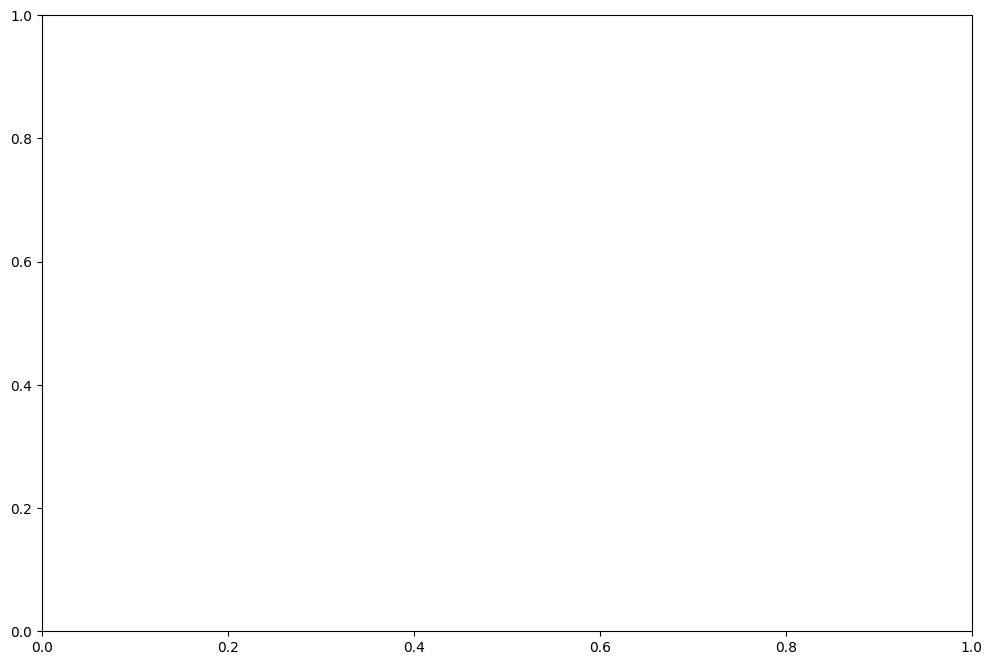

In [156]:
# plot training progress
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(np.arange(1,n_epochs+1),losses_train, label="Train")
ax.plot(np.arange(1,n_epochs+1),losses_test, label="Test")
ax.set(title="Losses vs Epochs", xlabel = "Epoch", ylabel = "MSE")
ax.legend()
plt.show()

#### Questions
1. How do the training and test losses above compare?
2. Play around with different numbers of hidden layers and number of neurons in the MLP. How is the performance of the model affected?
3. Play around with activation functions other than ReLU.